In [ ]:
import matplotlib.pyplot as plt
from zoning import *
from mobility_data_analysis_toolbox import *
from macroscopic_traffic_model import *
from statistical_models_and_forecasters import *
from macroscopic_traffic_model import Macroscopic_traffic_model

### Defne a (static and macroscopic) traffic model
 * uses Open street maps
 * we define a model for TelAviv and one for Zurich

In [ ]:
TelAviv = Macroscopic_traffic_model(geographical_area = 'Tel Aviv, Israel')
Zurich = Macroscopic_traffic_model(geographical_area = 'Zurich, CH')

### Methods of the static macroscopic traffic model

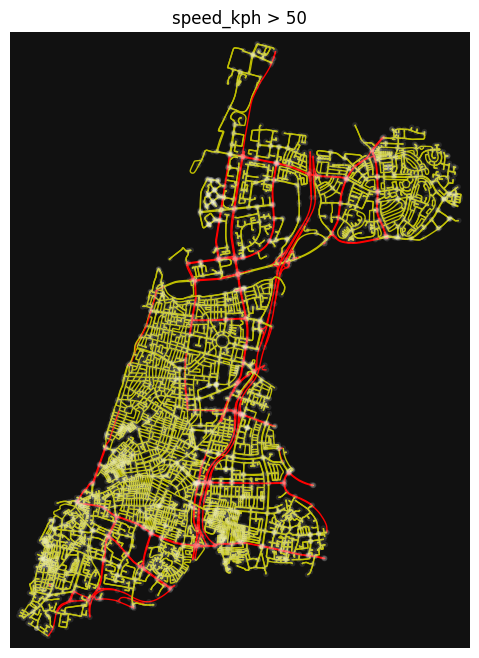

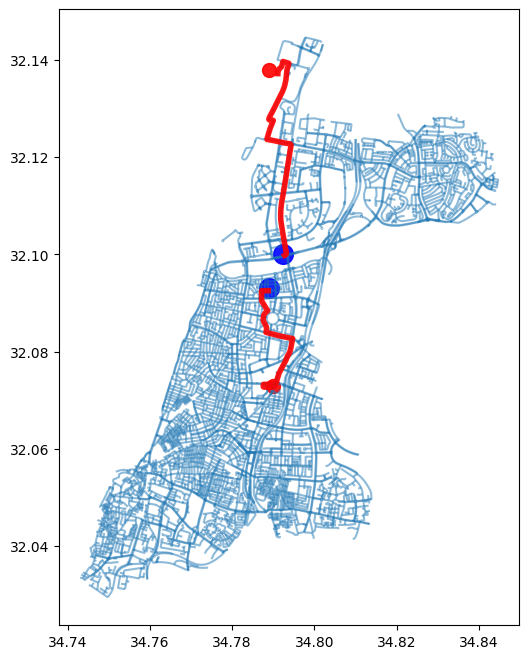

In [17]:
lon_min, lon_max, lat_min, lat_max = TelAviv.get_minmax_lon_lat() # get minimum and maximum latitudes, longitudes from the street graph
TelAviv.plot_graph_data(feature = 'speed_kph', data_threshold = 50) # in red are streets with speed >= 50 kph
#TelAviv.plot_graph_data(feature = 'travel_time', data_threshold = 60) # in red are streets with travel_time >= 60 seconds
#TelAviv.plot_graph_data(feature = 'length', data_threshold = 100) # in red are streets with length >= 20 meters
#TelAviv.plot_graph_data(feature = 'highway', data_threshold = 'residential') # in red are branches labelled as residential streets
df_edges = TelAviv.create_edge_dataframe() # get lat,lon start-end of the edges/streets
path = TelAviv.shortest_path_start_end(LO_LA_start= [34.79, 32.073], LO_LA_end = [34.791, 32.09] ) # get (if exist) the shortest path/route from start to end (latitude,longitude)
df_trips = pd.DataFrame([[1, 34.79, 32.073, 34.789, 32.093, 9], [2, 34.789, 32.138, 34.7923, 32.1, 12]],
                        columns=['reservation_id', 'startLongitude', 'startLatitude', 'endLongitude', 'endLatitude', 'distance']) # example of trip data set
TelAviv.plot_trip_routes(df_trips, show=True, route_alpha=0.9)
routes, df_route_features = TelAviv.get_shortest_routes_and_features(df_trips) # routes= list of routes, df_route_features= data frame with features of the trip and shortest routes

### load carsharing data

In [ ]:
df = data_loader(data_dir='datasets/autotel', file_name='autotel_2021_2022.pkl')
df, df_sequence = preprocess_trip_data_frame(df,lon_min, lon_max, lat_min, lat_max) # df_sequence is a reshaped dataset where we split booking events (is_start =True) and idle events (is_start =False)

In [ ]:
df_Zh_one_day_sim  = data_loader(data_dir='datasets/mobility/simulated', file_name='sim_reserv_df_in_zurich_1_day_from_userdemand.csv')
df_Zh_six_month_sim = data_loader(data_dir='datasets/mobility/simulated', file_name='sim_presence_matrx_in_zurich_6_months_statistical_sampler.csv')

In [ ]:
fig, AXs = plt.subplots(1,4, figsize=(18,2))
for car_id, ax in enumerate(AXs):
    ax.plot(df_Zh_six_month_sim.iloc[car_id,2:][:1000].values, label='simulated availability of car ID: ' + str(car_id))
    ax.legend(loc='best')
    ax.set_xlabel('time step')
    ax.set_ylabel('availability')
    ax.set_yticks([0,1])

In [ ]:
# get daily mobility info # 'matrix_daily_arrivals', 'results_daily', 'matrix_mean_distances', 'matrix_mean_idle', 'car_id_parked_per_day', 'mean_daily_arrivals', 'mean_daily_departures'
results_daily = get_daily_profiles_data(df_sequence)
statistical_demands = historical_hourly_demand(df_sequence)# plot departure, arrival and net car outflow profiles (daily profiles from historical data)

### example of zoning and analysis
* discretize street map in nlat x nlon rectangular areas and append the zone index to the data frame
* compute mean and variance of idle time and trip duration for each zone
* plot the results on the steet network

In [ ]:
n_disretized_lat_lon = [15, 15]
df_sequence, linspace_lat, linspace_lon = define_zones(df_sequence, n_disretized_lat_lon=n_disretized_lat_lon)
Idle_duration_zone_stats, Trips_duration_zone_stats = matrix_stats_idle_duration(df_sequence)
plot_zone_duration_stats(Idle_duration_zone_stats['mean'], Idle_duration_zone_stats['std'], TelAviv,  label1='Mean idle time', label2='STD idle time')
plot_zone_duration_stats(Trips_duration_zone_stats['mean'], Trips_duration_zone_stats['std'], TelAviv, label1='Mean trip duration', label2='STD trip duration')
plot_density_arrivals_departures_net_out_flows(Trips_duration_zone_stats['n_samples'],  Idle_duration_zone_stats['n_samples'], TelAviv)

### Example of forecaster for the total mobility demand in Tel Aviv (forecast total number of departures):
* prepare data set
* train and save a Mobility forecaster
* load the forecaster and predict

In [ ]:
# Create and fit the model
model_wrapper = MobilityDemandForecaster()
H_past, H_future =12, 24
X_tst, y_tst , X, y = prepare_forecaster_data(df_sequence, H_past=H_past, H_future=H_future,n_test=2500)
model_wrapper.fit(X, y)
model_dir = 'models/autotel' # Specify the subfolder path
if not os.path.exists(model_dir): # Create the subfolder if it doesn't exist
    os.makedirs(model_dir)
model_save_path = os.path.join(model_dir, 'model_wrapper.pkl')
with open(model_save_path, 'wb') as f: # Save the entire class with trained parameters in the subfolder
    pickle.dump(model_wrapper, f)

In [ ]:
# Load the model wrapper
with open(model_save_path, 'rb') as f:
    model_wrapper = pickle.load(f)
# Access the trained parameters
best_parameters = model_wrapper.best_parameters
# Use the model wrapper and its trained parameters
prediction, uncertainty_band = model_wrapper.predict(X_tst)

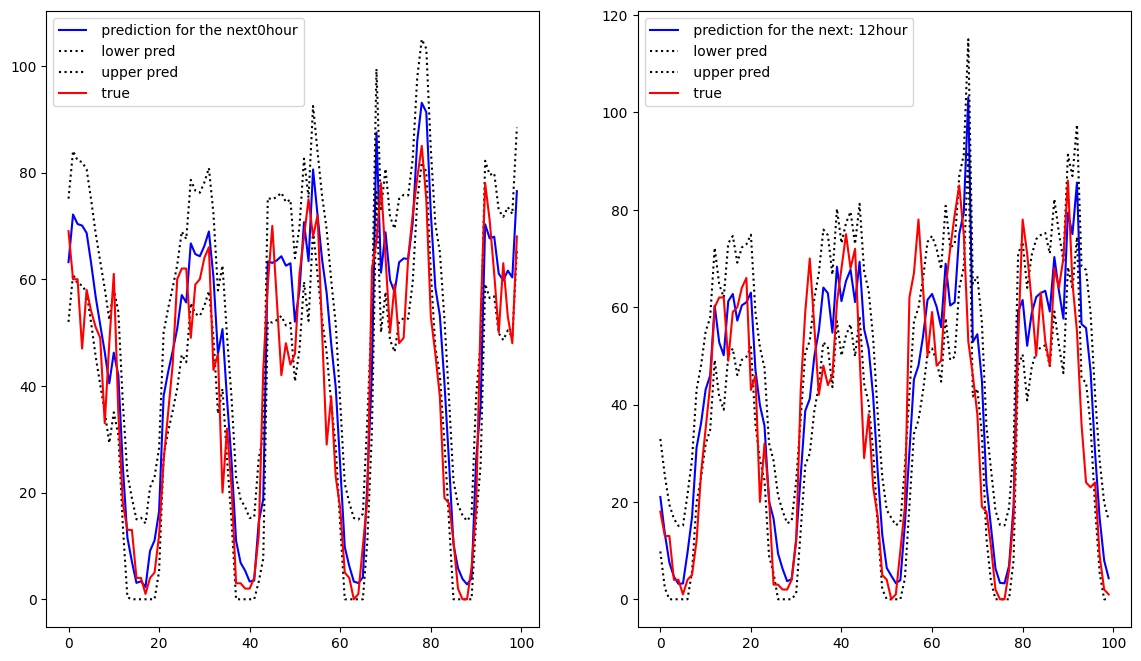

In [16]:
predict_t, T_plot = 0, 100
fig, ax = plt.subplots(1,2, figsize=(14,8))
ax[0].plot(prediction[:,predict_t][:T_plot],'b', label = ' prediction for the next' +str(predict_t)+'hour')
ax[0].plot(uncertainty_band[0][:,predict_t][:T_plot],':k', label = ' lower pred')
ax[0].plot(uncertainty_band[1][:,predict_t][:T_plot],':k', label = ' upper pred')
ax[0].plot(y_tst.iloc[:,predict_t][:T_plot], 'r', label = ' true'); ax[0].legend()
predict_t = 12
ax[1].plot(prediction[:,predict_t][:T_plot],'b', label = ' prediction for the next: '+str(predict_t) +'hour')
ax[1].plot(uncertainty_band[0][:,predict_t][:T_plot],':k', label = ' lower pred')
ax[1].plot(uncertainty_band[1][:,predict_t][:T_plot],':k', label = ' upper pred')
ax[1].plot(y_tst.iloc[:,predict_t][:T_plot], 'r', label = ' true')
plt.legend()


In [ ]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
# Generate some latitude and longitude data
df_masked = df_sequence[(df_sequence['is_start']==True) & (df_sequence['hour']==0)]
data= df_masked[['LAT','LON']].to_numpy()
# Construct the KDE estimator
kde = KernelDensity(bandwidth=0.001)  # Adjust the bandwidth as needed
kde.fit(data)
# Generate sample points for evaluation
sample_points = df_masked[['LAT','LON']]
# Evaluate the log density at the sample points
log_density = kde.score_samples(sample_points)
print("Log Density:", log_density)

In [ ]:
# Generate sample points for evaluation
sample_points = np.column_stack((df_masked['LAT'], df_masked['LON']))
# Evaluate the log density at the sample points
log_density = kde.score_samples(sample_points)
# Plot the kernel density
plt.scatter( df_masked['LON'],df_masked['LAT'], c=np.exp(log_density), cmap='viridis')
plt.colorbar(label='Kernel Density')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Kernel Density Estimation')
plt.show()